In [1]:
import os, sys, time, copy
import random
import numpy as np
import matplotlib.pyplot as plt

import multiprocessing
from functools import partial
from tqdm import tqdm


import myokit
sys.path.append('../')
sys.path.append('../Protocols')
sys.path.append('../Models')
sys.path.append('../Lib')
import protocol_lib
import mod_trace

import simulator_myokit
import simulator_scipy
import vc_protocols

In [2]:
def find_closest_index(array, t):
    """Given an array, return the index with the value closest to t."""
    return (np.abs(np.array(array) - t)).argmin()

def get_currents_with_constant_dt(xs, window=1, step_size=1):
        
    times = xs[0]
    currents = xs[1:]
        
    data_li = []
    for I in currents:        
        data_temp = []
        t = 0
        while t <= times[-1] - window:
            start_index = find_closest_index(times, t)
            end_index = find_closest_index(times, t + window)            
            I_window = I[start_index: end_index + 1]                                    
            data_temp.append(sum(I_window)/len(I_window))            
            t += step_size
        data_li.append(data_temp)                                        
            
    return data_li

In [3]:
cell_types = {
    'Endocardial' : 0,
    'Epicardial' : 1,
    'Mid-myocardial' : 2,
}

### Create Voltage Protocol

In [4]:
# '''
# leemV1
# '''
# # VC_protocol = vc_protocols.hERG_CiPA()
# # VC_protocol = vc_protocols.cav12_CiPA()
# # VC_protocol = vc_protocols.lateNav15_CiPA()

# VC_protocol = protocol_lib.VoltageClampProtocol()  # steps=steps
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-90, duration=100) )
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-35, duration=40) )
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=200) )
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-40, duration=40) )
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=40) )  # <- why?? vo
# VC_protocol.add( protocol_lib.VoltageClampStep(voltage=40, duration=500) )
# VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=40, voltage_end=-120, duration=200)) # ramp step
# # VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
# # VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=100) )
# # VC_protocol.add( protocol_lib.VoltageClampStep(voltage=60, duration=500) )
# # VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=60, voltage_end=-80, duration=200)) # ramp step

# vhold = VC_protocol.steps[0].voltage

# print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} ms')

In [5]:
'''
SongV1
'''
VC_protocol = protocol_lib.VoltageClampProtocol()  # steps=steps

VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=100) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-120, duration=20) ) 
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-40, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=60, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=0, duration=200) )  # <- why?? vo
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=50, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-10, duration=200) )
VC_protocol.add( protocol_lib.VoltageClampStep(voltage=-80, duration=50) )
VC_protocol.add( protocol_lib.VoltageClampRamp(voltage_start=30, voltage_end=-50, duration=100)) # ramp step

vhold = -80

print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} ms')

The protocol is 1270 ms


In [6]:
start_time = time.time()

model, p, s = myokit.load("../mmt-model-files/ohara-cipa-v1-2017_JK-v1.mmt")    
sim = simulator_myokit.Simulator(model, VC_protocol, max_step=1.0, abs_tol=1e-06, rel_tol=1e-6, vhold=vhold)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "ohara2017"  

f = 1.5
params = {         
    'cell.mode': cell_types['Mid-myocardial'],
    'setting.simType': 1,   # 0: AP   |  1: VC  
    
    'ina.gNa' : 75.0 * f,   
    'inal.gNaL' : 0.0075 * 2.661 * f,  
    'ito.gto' : 0.02 * 4 * f,
    'ical.PCa' : 0.0001 * 1.007 * 2.5 * f,
    'ikr.gKr' : 4.65854545454545618e-2 * 1.3 * f, # [mS/uF]
    'iks.gKs' : 0.0034 * 1.87 * 1.4 * f,
    'ik1.gK1' : 0.1908 * 1.698 * 1.3 * f,
    'inaca.gNaCa' : 0.0008 * 1.4,
    'inak.PNaK' : 30 * 0.7,
    'ikb.gKb' : 0.003,
    'inab.PNab' : 3.75e-10,
    'icab.PCab' : 2.5e-8,
    'ipca.GpCa' : 0.0005,
}
sim.set_simulation_params(params)

print("--- %s seconds ---"%(time.time()-start_time))

--- 3.749445676803589 seconds ---


In [7]:
for key, value in params.items():
    print(f'{key} : {value}')

cell.mode : 2
setting.simType : 1
ina.gNa : 112.5
inal.gNaL : 0.029936249999999998
ito.gto : 0.12
ical.PCa : 0.0003776249999999999
ikr.gKr : 0.0908416363636364
iks.gKs : 0.0133518
ik1.gK1 : 0.6317578800000001
inaca.gNaCa : 0.00112
inak.PNaK : 21.0
ikb.gKb : 0.003
inab.PNab : 3.75e-10
icab.PCab : 2.5e-08
ipca.GpCa : 0.0005


In [8]:
def gen_dataset( gen_params, datasetNo=1):    
    '''
    type = 'AP' or 'I" 
    params = {
        'times': 1,                    
        'log_li' : [],
        'nData' : 10000,                         
        'dataset_dir' :   './dataset',
        'data_file_name' :  'current',
        'scale' : 2,
    }  
    '''
    random.seed(datasetNo * 84)
    np.random.seed(datasetNo * 86)

    print("-----Dataset%d generation starts.-----"%(datasetNo))

    d = None              
    result_li = []
    param_li = []
    current_nData = 0
    
    simulation_error_count = 0
    with tqdm(total = gen_params['nData']) as pbar: 
        while (current_nData < gen_params['nData']):                
            g_adj = np.random.uniform(0, 1, 7)                      
            
            g_adj_li= {                    
                'ina.g_adj' : g_adj[0],
                'inal.g_adj' : g_adj[1],
                'ito.g_adj' : g_adj[2],
                'ical.g_adj' : g_adj[3],
                'ikr.g_adj' : g_adj[4],
                'iks.g_adj' : g_adj[5],
                'ik1.g_adj' : g_adj[6],
                # 'if.g_adj' : g_fc[7]    
            } 
            sim.set_simulation_params(g_adj_li)                
            # log_li = ['membrane.V']
            # if len(log_li)>0:
            #     log_li = gen_params['log_li']
            try :                
                sim.pre_simulate(5000, sim_type=1)
                d = sim.simulate( gen_params['end_time'], extra_log=gen_params['log_li'])                           

                temp = [d['engine.time']]
                for log in gen_params['save_log_li'] :                                              
                    temp.append(d[log])                 
                temp = get_currents_with_constant_dt(temp, window=gen_params['window'], step_size=gen_params['step_size'])

                result_li.append( np.array(temp) )
                param_li.append( g_adj )
                current_nData+=1                    
                
            except :
                simulation_error_count += 1
                print("There is a simulation error.")
                continue
                
            pbar.update(1) 
        
    result_li = np.array(result_li)        
    param_li = np.array(param_li)        
    np.save(os.path.join(gen_params['dataset_dir'], f"{gen_params['data_file_name']}{datasetNo}" ) , result_li)
    np.save(os.path.join(gen_params['dataset_dir'], f'parameter{datasetNo}' ), param_li )

    result_li = []
    param_li = []

    print("=====Dataset%d generation End.  &  %d simulation errors occured.====="%(datasetNo, simulation_error_count))       

The number of process : 72
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
The folder already exists.


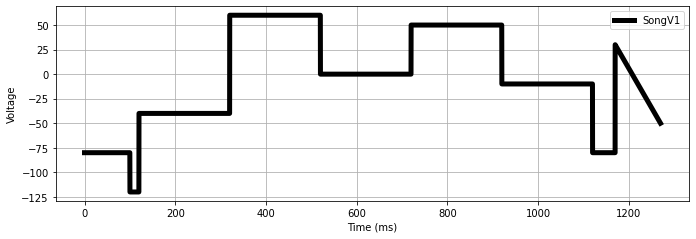

-----Dataset4 generation starts.----------Dataset3 generation starts.----------Dataset1 generation starts.----------Dataset2 generation starts.----------Dataset5 generation starts.----------Dataset6 generation starts.----------Dataset10 generation starts.----------Dataset12 generation starts.----------Dataset7 generation starts.----------Dataset8 generation starts.----------Dataset9 generation starts.----------Dataset11 generation starts.----------Dataset13 generation starts.----------Dataset15 generation starts.----------Dataset14 generation starts.-----



-----Dataset19 generation starts.----------Dataset18 generation starts.----------Dataset17 generation starts.----------Dataset21 generation starts.----------Dataset16 generation starts.-----

-----Dataset25 generation starts.----------Dataset20 generation starts.----------Dataset22 generation starts.-----

-----Dataset23 generation starts.----------Dataset26 generation starts.-----

-----Dataset29 generation starts.-----
-----Datas

  0%|                                                 | 0/10000 [00:00<?, ?it/s]

  0%|                                                 | 0/10000 [00:00<?, ?it/s]

  0%|                                                 | 0/10000 [00:00<?, ?it/s]

  0%|                                                 | 0/10000 [00:00<?, ?it/s]

  0%|                                                 | 0/10000 [00:00<?, ?it/s]

  1%|▎                                       | 77/10000 [00:24<52:04,  3.18it/s]

There is a simulation error.


 22%|████████▏                             | 2160/10000 [11:00<38:49,  3.37it/s]

There is a simulation error.


 31%|███████████▊                          | 3117/10000 [16:02<36:10,  3.17it/s]

There is a simulation error.


 35%|█████████████▏                        | 3460/10000 [17:38<31:44,  3.43it/s]

There is a simulation error.

 35%|█████████████                         | 3453/10000 [17:38<33:51,  3.22it/s]

 37%|██████████████▏                       | 3718/10000 [18:58<32:48,  3.19it/s]

There is a simulation error.


 67%|█████████████████████████▌            | 6735/10000 [34:44<17:10,  3.17it/s]

There is a simulation error.


 83%|███████████████████████████████▋      | 8345/10000 [42:42<08:11,  3.37it/s]

There is a simulation error.


 96%|████████████████████████████████████▌ | 9622/10000 [49:27<01:53,  3.33it/s]

In [ ]:
if __name__=='__main__':
    start_time = time.time()    
    nCPU = os.cpu_count()          
    print("The number of process :", nCPU )   
   
    multi = True
    
    gen_params = {
        'end_time': VC_protocol.get_voltage_change_endpoints()[-1],                            
        'log_li' : ['membrane.i_ion', 'ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ical.ICaNa', 'ical.ICaK', 'ikr.IKr', 'iks.IKs', 'ik1.IK1', 'inaca.INaCa', 'inacass.INaCa_ss', 'inak.INaK', 'ikb.IKb', 'inab.INab', 'icab.ICab', 'ipca.IpCa'],
        'save_log_li' : ['membrane.i_ion', 'ina.INa', 'inal.INaL', 'ito.Ito', 'ical.ICaL', 'ikr.IKr', 'iks.IKs',  'ik1.IK1'],
        'nData' : 10000,                         
        'dataset_dir' : './ohara2017_songV1',
        'data_file_name' : 'currents',
        'window' : 10,
        'step_size' : 5,
        'startNo' : 1,
        'nDataset' : 30,
    }  
    gen_params['dataset_dir'] = gen_params['dataset_dir'] + f"_w{gen_params['window']}_s{gen_params['step_size']}"

    datasetNo_li = list(range(gen_params['startNo'], gen_params['startNo']+gen_params['nDataset']))  # Core 수만큼  [1,2,3,4,5,6,7,8,9,10]    
    print(datasetNo_li)          
        
    try:
        if not os.path.exists(gen_params['dataset_dir']):
            os.makedirs(gen_params['dataset_dir'])
            print('"%s" has been created.'%(gen_params['dataset_dir']))
        else:
            print("The folder already exists.")
    except OSError:
        print('Error: create_folder(). : ' + gen_params['dataset_dir'])
        
    
    '''
    Plot
    '''
    fig, ax = plt.subplots(1,1, figsize=(10,3))    
    # fig.suptitle(sim.name, fontsize=14)
    # ax.set_title('Simulation %d'%(simulationNo))
    # axes[i].set_xlim(model_scipy.times.min(), model_scipy.times.max())
    # ax.set_ylim(ylim[0], ylim[1])
    ax.set_xlabel('Time (ms)')       
    ax.set_ylabel(f'Voltage')      
    times = np.linspace(0, VC_protocol.get_voltage_change_endpoints()[-1], 10000)  
    ax.plot( times, VC_protocol.get_voltage_clamp_protocol(times), label='SongV1', color='k', linewidth=5)     
    ax.legend()
    ax.grid()
    # ax[-1].set_ylim(-5, 5)

    plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.95, wspace=0.5, hspace=0.15)
    plt.show()
    fig.savefig(os.path.join(gen_params['dataset_dir'], "aVC.jpg" ), dpi=100)

    
         
    if multi :            
        pool = multiprocessing.Pool(processes=gen_params['nDataset'] )
        func = partial(gen_dataset, gen_params)
        pool.map(func, datasetNo_li)
        pool.close()
        pool.join()
    else:
        for No in datasetNo_li :
            gen_dataset(gen_params, No)
        
    # print("Dataset has been generated.")
    
    print("--- %s seconds ---"%(time.time()-start_time))
    
    # 

    # # Set parameter transformation
    # transform_to_model_param = log_transform_to_model_param       # return np.exp(out)
    # transform_from_model_param = log_transform_from_model_param   # return np.log(out)
    
    # logprior = LogPrior(transform_to_model_param, transform_from_model_param)
      
    # p = logprior.sample_without_inv_transform()
    # print(p)
    
    # print(logprior.rmax)
    # print(logprior.rmin)
    # print(5e5)

 

In [12]:
print("Finish")

Finish
